# Training of a Feed Forward Neural Network for Classification with Pytorch:

Data obtained from National Institute of Diabetes and Digestive and Kidney Diseases pima indians dataset

FILES REQUIRED: Upload the pima-indians-diabetes.csv file to the directory.

FILES GENERATED: The .pt (model), and a .csv file with input data for a request to submit through the API.

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import pickle

from sklearn.metrics import mean_squared_error, confusion_matrix, r2_score, accuracy_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import  train_test_split

In [4]:
# Load the dataset, split into input (X) and output (y) variables
dataset = np.loadtxt('pima-indians-diabetes.csv', delimiter=',')
X = dataset[:,0:8]
y = dataset[:,8]

print(X.shape, y.shape)

(768, 8) (768,)


In [5]:
# Balancing the data:

# We only have two categories:
filter_y_0 = y == 0.0
filter_y_1 = y == 1.0

y_class_0 = y[filter_y_0]
y_class_1 = y[filter_y_1]

X_class_0 = X[filter_y_0,:]
X_class_1 = X[filter_y_1,:]

# Get the number of instances of the smallest category:
min_cat = np.min( [len(y_class_0), len(y_class_1)] )

# Balancing:
bal_y = np.concatenate( (y_class_0[:min_cat], y_class_1[:min_cat]), axis=0 )
bal_X = np.concatenate( (X_class_0[:min_cat,:], X_class_1[:min_cat,:]), axis=0)

In [6]:
# Separate in training and validation:
X_train, X_valid, y_train, y_valid = train_test_split(bal_X, bal_y,test_size=0.4,random_state=79)

# Scale the data with the information of the training set:
scaler = MinMaxScaler()
scaler.fit(X_train)
Xs_train = scaler.transform(X_train)
Xs_valid = scaler.transform(X_valid)

In [7]:
Xs_train = torch.tensor(Xs_train, dtype=torch.float32)
Xs_valid = torch.tensor(Xs_valid, dtype=torch.float32)

y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
y_valid = torch.tensor(y_valid, dtype=torch.float32).reshape(-1, 1)

In [8]:
# Define the model
user_model = nn.Sequential(
    nn.Linear(8, 64),
    nn.GELU(),
    nn.Dropout(p=0.1),
    nn.Linear(64, 128),
    nn.Tanh(),
    nn.Linear(128, 1),
    nn.Sigmoid()
)
print(user_model)

Sequential(
  (0): Linear(in_features=8, out_features=64, bias=True)
  (1): GELU(approximate='none')
  (2): Dropout(p=0.1, inplace=False)
  (3): Linear(in_features=64, out_features=128, bias=True)
  (4): Tanh()
  (5): Linear(in_features=128, out_features=1, bias=True)
  (6): Sigmoid()
)


In [9]:
# Specs for the training the model
loss_fn   = nn.BCELoss()  # binary cross entropy
optimizer = optim.Adam(user_model.parameters(), lr=0.0001)

n_epochs = 200
batch_size = 10

In [10]:
# Train:

# Storage of losses:
arr_losses_train = []
arr_losses_valid = []

# Loop:
for epoch in range(n_epochs):
    for i in range(0, len(X), batch_size):
        # Training:
        Xs_train_batch = Xs_train[i:i+batch_size]
        y_train_batch_pred = user_model(Xs_train_batch)
        y_train_batch = y_train[i:i+batch_size]
        # Compare loss:
        loss = loss_fn(y_train_batch_pred, y_train_batch)
        # Get gradients:
        optimizer.zero_grad()
        # Loss and optimization:
        loss.backward()
        optimizer.step()
    # Get loss for validation:
    y_train_pred = user_model(Xs_train)
    y_valid_pred = user_model(Xs_valid)
    loss_train = loss_fn(y_train_pred, y_train)
    loss_valid = loss_fn(y_valid_pred, y_valid)
    # Store:
    arr_losses_train.append(loss_train.item())
    arr_losses_valid.append(loss_valid.item())
    # Print epoch info:
    print(f'Finished epoch {epoch}. Train loss: {loss_train}. Valid loss: {loss_valid}')

Finished epoch 0. Train loss: 0.6907790899276733. Valid loss: 0.6905149817466736
Finished epoch 1. Train loss: 0.6906084418296814. Valid loss: 0.688625156879425
Finished epoch 2. Train loss: 0.6869980096817017. Valid loss: 0.6832635998725891
Finished epoch 3. Train loss: 0.6856452226638794. Valid loss: 0.6833007335662842
Finished epoch 4. Train loss: 0.6828821301460266. Valid loss: 0.6816604733467102
Finished epoch 5. Train loss: 0.6791130900382996. Valid loss: 0.6760507225990295
Finished epoch 6. Train loss: 0.6765738725662231. Valid loss: 0.6748478412628174
Finished epoch 7. Train loss: 0.6732136011123657. Valid loss: 0.6710624694824219
Finished epoch 8. Train loss: 0.668359100818634. Valid loss: 0.665814220905304
Finished epoch 9. Train loss: 0.666269063949585. Valid loss: 0.6624069809913635
Finished epoch 10. Train loss: 0.6650881767272949. Valid loss: 0.6606817841529846
Finished epoch 11. Train loss: 0.6609350442886353. Valid loss: 0.6555030941963196
Finished epoch 12. Train loss:

Text(0.5, 1.0, 'Evolution of the Error')

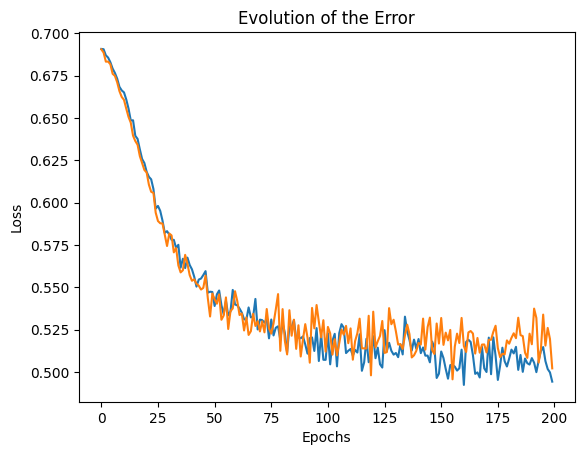

In [11]:
plt.plot(arr_losses_train)
plt.plot(arr_losses_valid)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title('Evolution of the Error')

In [12]:
# Compute accuracy (no_grad is optional)
with torch.no_grad():
    y_train_pred = user_model(Xs_train)
    y_valid_pred = user_model(Xs_valid)
accuracy_train = (y_train_pred.round() == y_train).float().mean()
accuracy_valid = (y_valid_pred.round() == y_valid).float().mean()
print(f"Train Accuracy {accuracy_train}")
print(f"Valid Accuracy {accuracy_valid}")

Train Accuracy 0.7352024912834167
Valid Accuracy 0.734883725643158


In [13]:
# Convert the predictions to labels:
label_y_train_pred = np.round(y_train_pred)
label_y_valid_pred = np.round(y_valid_pred)

In [14]:
cm_train = confusion_matrix(label_y_train_pred, y_train)
cm_valid = confusion_matrix(label_y_valid_pred, y_valid)

Text(0.5, 23.52222222222222, 'True Label')

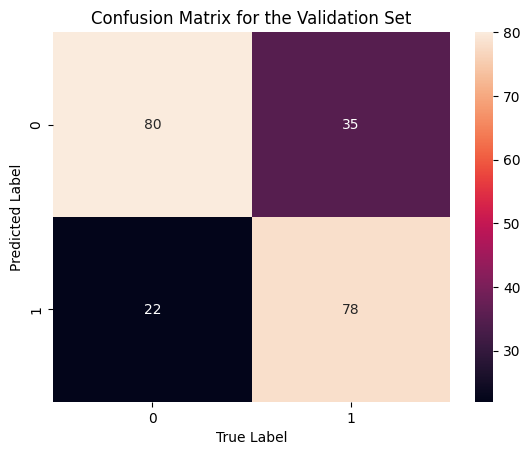

In [15]:
# For the Validation:
sn.heatmap(cm_valid, annot=True)
plt.title('Confusion Matrix for the Validation Set')
plt.ylabel('Predicted Label')
plt.xlabel('True Label')

In [16]:
# Export/Load Model in TorchScript Format
# https://pytorch.org/tutorials/beginner/saving_loading_models.html#export-load-model-in-torchscript-format
# Recommended format for Pytorch:

In [17]:
# If we save the model using TorchScript we cannot use the hooks to get intermediate outputs:
# model_scripted = torch.jit.script(user_model) # Export to TorchScript
# model_scripted.save('model_scripted.pt')

# Have a message that says please do not save in TorchScript format

In [18]:
torch.save(user_model, 'user_model.pt')

# Save the Data to Simulate a Future Request from the User

In [19]:
# We will simply use the Xs of the validation set for a future request:
df = pd.DataFrame(Xs_valid, index=None, columns=None)
df.to_csv('input_data_for_the_request.csv', index=True, columns=None)

# Read the model and the data and predict:

In [20]:
# Read the model if TorchScript:
# read_model = torch.jit.load('model_scripted.pt')
# read_model.eval()

In [21]:
# Read the model:
read_model = torch.load('user_model.pt')
read_model.eval()

Sequential(
  (0): Linear(in_features=8, out_features=64, bias=True)
  (1): GELU(approximate='none')
  (2): Dropout(p=0.1, inplace=False)
  (3): Linear(in_features=64, out_features=128, bias=True)
  (4): Tanh()
  (5): Linear(in_features=128, out_features=1, bias=True)
  (6): Sigmoid()
)

In [22]:
# Read the data submitted:
df_read = pd.read_csv('input_data_for_the_request.csv', index_col=0, header=0)
df_read.head()

,0,1,2,3,4,5,6,7
0,0.428571,0.522613,0.606557,0.285714,0.184397,0.503367,0.274979,0.408163
1,0.071429,0.427136,0.540984,0.460317,0.000000,0.447811,0.116567,0.204082
2,0.500000,0.753769,0.540984,0.666667,0.404255,0.584175,0.273271,0.428571
3,0.357143,0.391960,0.393443,0.000000,0.000000,0.567340,0.245944,0.081633
4,0.642857,0.653266,0.573770,0.000000,0.000000,0.575758,0.245090,0.489796


In [23]:
# Get the input data:
X_submitted = df_read.to_numpy()
print(X_submitted.shape)

(215, 8)


In [24]:
# Use the read model:
X_submitted = torch.tensor(X_submitted, dtype=torch.float32)
# The use of the with torch.no_grad() is optional:
with torch.no_grad():
  y_submitted_pred = read_model(X_submitted)